<a href="https://colab.research.google.com/github/jeshwanth-A/aiml_defi/blob/main/Aiml_Defi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Starting data processing...
Fetching fresh data from API...
Processed and saved data
Dataset size: 30 rows
Created 20 sequences
Train size: 16, Test size: 4

Training Random Forest baseline...
Random Forest MAE: 0.3476

=== PyTorch LSTM ===
Training PyTorch model...
Epoch 0, Loss: 0.2585
Epoch 10, Loss: 0.1265
Epoch 20, Loss: 0.1107
Epoch 30, Loss: 0.0938
Epoch 40, Loss: 0.0858
Saved PyTorch model
PyTorch LSTM MAE: 0.1894

=== TensorFlow LSTM ===
Training TensorFlow model...


Saved TensorFlow model
TensorFlow LSTM MAE: 0.2089

=== LLM Finetuning ===


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Finetuning LLM with LoRA...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Saved finetuned LLM

=== Creating Visualizations ===
Saved visualization to /content/drive/MyDrive/crypto_project/forecast_viz.png


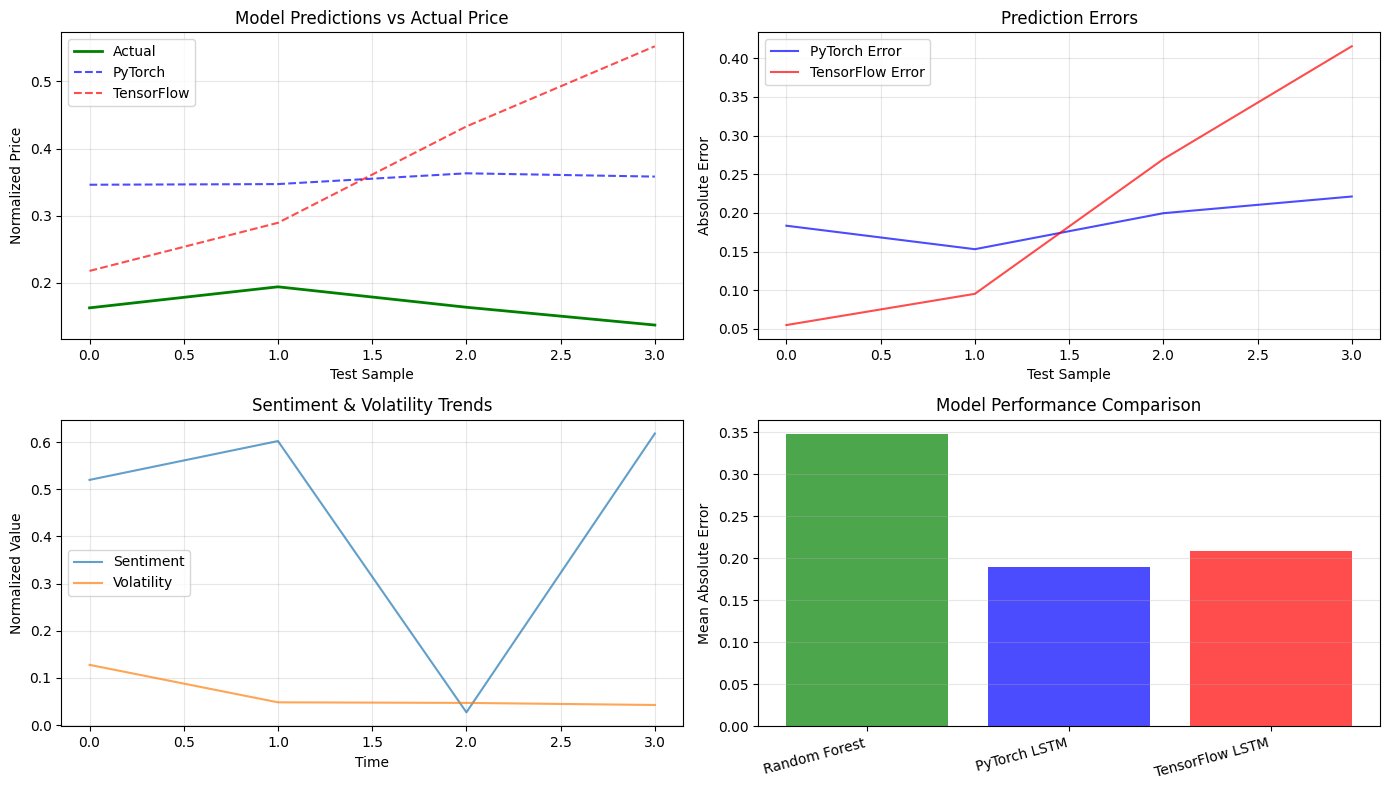


PROJECT COMPLETE!
Models saved to: /content/drive/MyDrive/crypto_project
Random Forest MAE: 0.3476
PyTorch LSTM MAE: 0.1894
TensorFlow LSTM MAE: 0.2089
Visualization saved to: /content/drive/MyDrive/crypto_project/forecast_viz.png


In [2]:
# Full Hybrid Crypto Sentiment Forecaster Code with Save/Load - FIXED FOR COLAB
# This script fetches crypto price data, adds mock sentiment, processes data,
# trains LSTM models, and visualizes predictions.

# Install packages (run once)
!pip install -q numpy pandas torch torchvision torchaudio
!pip install -q tensorflow
!pip install -q scikit-learn matplotlib
!pip install -q langchain langchain-community
!pip install -q transformers peft datasets accelerate
!pip install -q huggingface-hub

import os
import urllib.request
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import Dataset
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

# Define save paths for Colab
save_folder = '/content/drive/MyDrive/crypto_project'
os.makedirs(save_folder, exist_ok=True)
pt_model_path = os.path.join(save_folder, 'model_pt.pth')
tf_model_path = os.path.join(save_folder, 'model_tf.h5')
llm_path = os.path.join(save_folder, 'finetuned_llm')
data_path = os.path.join(save_folder, 'processed_data.csv')
scaler_path = os.path.join(save_folder, 'scaler.npy')

# Step 1: Fetch and Parse Price Data
def fetch_and_parse(token_id='uniswap', days=30):
    url = f"https://api.coingecko.com/api/v3/coins/{token_id}/market_chart?vs_currency=usd&days={days}&interval=daily"
    try:
        with urllib.request.urlopen(url) as response:
            data = response.read().decode("utf-8")
            json_data = json.loads(data)

        required_keys = ['prices', 'total_volumes']
        for key in required_keys:
            if key not in json_data:
                print(f"Warning: {key} is missing")
                return None

        prices = json_data.get('prices', [])
        volumes = json_data.get('total_volumes', [])

        if len(prices) == 0 or len(volumes) == 0:
            print("No data received from API")
            return None

        df = pd.DataFrame(prices, columns=['timestamp', 'price'])
        df['volume'] = [v[1] for v in volumes]
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
    except Exception as e:
        print(f"Exception fetching data: {e}")
        return None

# Step 2: Add Mock Sentiment Data
def add_sentiment(df):
    np.random.seed(42)
    df['sentiment'] = np.random.uniform(-1, 1, size=len(df))
    return df

# Step 3: Data Processing
print("Starting data processing...")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print("Loaded processed data from disk")
else:
    print("Fetching fresh data from API...")
    df = fetch_and_parse()
    if df is not None:
        df = df.dropna()
        df = add_sentiment(df)

        # Calculate volatility using NumPy
        prices_np = df['price'].values
        window_size = min(5, len(prices_np))
        if len(prices_np) >= window_size:
            volatility = np.std(np.lib.stride_tricks.sliding_window_view(prices_np, window_size), axis=1)
            df['volatility'] = np.pad(volatility, (window_size-1, 0), mode='edge')
        else:
            df['volatility'] = 0

        # Save unscaled data for reference
        df_unscaled = df.copy()

        # Scaling
        scaler = MinMaxScaler()
        df[['price', 'volume', 'sentiment', 'volatility']] = scaler.fit_transform(
            df[['price', 'volume', 'sentiment', 'volatility']]
        )

        # Lag features
        df['price_lag1'] = df['price'].shift(1)
        df = df.dropna()

        df.to_csv(data_path, index=False)
        print("Processed and saved data")
    else:
        print("Failed to fetch data. Exiting.")
        df = None

# Proceed only if data is available
if df is not None and len(df) > 0:
    print(f"Dataset size: {len(df)} rows")

    # Create sequences
    def create_sequences(data, seq_len=10):
        seq_len = min(seq_len, len(data) - 1)  # Adjust if data is too small
        X, y = [], []
        for i in range(len(data) - seq_len):
            X.append(data.iloc[i:i+seq_len].values)
            y.append(data.iloc[i+seq_len]['price'])
        return np.array(X), np.array(y)

    features = df[['price', 'volume', 'sentiment', 'volatility', 'price_lag1']]
    seq_length = min(10, len(features) // 2)
    X, y = create_sequences(features, seq_len=seq_length)

    if len(X) == 0:
        print("Not enough data to create sequences. Need more historical data.")
    else:
        print(f"Created {len(X)} sequences")

        # Split data
        split = max(1, int(0.8 * len(X)))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

        # Scikit-learn Baseline (Random Forest)
        if len(X_train) > 0:
            print("\nTraining Random Forest baseline...")
            rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10)
            rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
            rf_preds = rf.predict(X_test.reshape(X_test.shape[0], -1))
            print(f"Random Forest MAE: {mean_absolute_error(y_test, rf_preds):.4f}")

        # Step 4: PyTorch LSTM
        class PricePredictor(nn.Module):
            def __init__(self, input_size=5, hidden_size=50, num_layers=1):
                super().__init__()
                self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
                self.fc = nn.Linear(hidden_size, 1)

            def forward(self, x):
                out, _ = self.lstm(x)
                out = self.fc(out[:, -1, :])
                return out

        print("\n=== PyTorch LSTM ===")
        model_pt = PricePredictor(input_size=X_train.shape[2])

        if os.path.exists(pt_model_path):
            model_pt.load_state_dict(torch.load(pt_model_path))
            print("Loaded PyTorch model from disk")
        else:
            print("Training PyTorch model...")
            optimizer = torch.optim.Adam(model_pt.parameters(), lr=0.001)
            criterion = nn.MSELoss()
            X_train_pt = torch.tensor(X_train, dtype=torch.float32)
            y_train_pt = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

            for epoch in range(50):
                model_pt.train()
                outputs = model_pt(X_train_pt)
                loss = criterion(outputs, y_train_pt)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

            torch.save(model_pt.state_dict(), pt_model_path)
            print("Saved PyTorch model")

        # Evaluate PyTorch model
        model_pt.eval()
        with torch.no_grad():
            X_test_pt = torch.tensor(X_test, dtype=torch.float32)
            preds_pt = model_pt(X_test_pt).numpy()

        pt_mae = mean_absolute_error(y_test, preds_pt)
        print(f"PyTorch LSTM MAE: {pt_mae:.4f}")

        # Step 5: TensorFlow LSTM
        print("\n=== TensorFlow LSTM ===")
        if os.path.exists(tf_model_path):
            model_tf = tf.keras.models.load_model(tf_model_path)
            print("Loaded TensorFlow model from disk")
        else:
            print("Training TensorFlow model...")
            model_tf = Sequential([
                LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                Dense(1)
            ])
            model_tf.compile(optimizer='adam', loss='mse')
            model_tf.fit(X_train, y_train, epochs=50, batch_size=max(1, len(X_train)//10), verbose=0)
            model_tf.save(tf_model_path)
            print("Saved TensorFlow model")

        preds_tf = model_tf.predict(X_test, verbose=0)
        tf_mae = mean_absolute_error(y_test, preds_tf)
        print(f"TensorFlow LSTM MAE: {tf_mae:.4f}")

        # Step 6: LLM Finetuning with LoRA (Simplified)
        print("\n=== LLM Finetuning ===")

        # Create mock training data for explanation model
        explanation_data = {
            'text': [
                "The prediction was close to actual value, showing good model performance.",
                "Large prediction error indicates model needs improvement.",
                "Price increased but prediction was lower, missing upward trend.",
                "Sentiment was positive and price rose as expected."
            ],
            'label': [1, 0, 0, 1]  # 1: good prediction, 0: poor prediction
        }
        dataset = Dataset.from_dict(explanation_data)

        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

        def preprocess(examples):
            return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

        dataset = dataset.map(preprocess, batched=True)
        dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

        if os.path.exists(os.path.join(llm_path, 'adapter_config.json')):
            print("Loading finetuned LLM...")
            base_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
            model_llm = PeftModel.from_pretrained(base_model, llm_path)
            print("Loaded finetuned LLM")
        else:
            print("Finetuning LLM with LoRA...")
            lora_config = LoraConfig(
                r=8,
                lora_alpha=32,
                target_modules=["q_lin", "v_lin"],
                lora_dropout=0.1,
                bias="none",
                task_type="SEQ_CLS"
            )
            base_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
            model_llm = get_peft_model(base_model, lora_config)

            training_args = TrainingArguments(
                output_dir="./results",
                num_train_epochs=3,
                per_device_train_batch_size=2,
                save_strategy="epoch",
                logging_steps=10,
                report_to="none"
            )
            trainer = Trainer(
                model=model_llm,
                args=training_args,
                train_dataset=dataset
            )
            trainer.train()
            model_llm.save_pretrained(llm_path)
            print("Saved finetuned LLM")

        # Step 7: Visualizations
        print("\n=== Creating Visualizations ===")

        fig = plt.figure(figsize=(14, 8))

        # Plot 1: Predictions vs Actual
        plt.subplot(2, 2, 1)
        test_indices = range(len(y_test))
        plt.plot(test_indices, y_test, 'g-', label='Actual', linewidth=2)
        plt.plot(test_indices, preds_pt, 'b--', label='PyTorch', alpha=0.7)
        plt.plot(test_indices, preds_tf, 'r--', label='TensorFlow', alpha=0.7)
        plt.xlabel('Test Sample')
        plt.ylabel('Normalized Price')
        plt.title('Model Predictions vs Actual Price')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: Prediction Errors
        plt.subplot(2, 2, 2)
        pt_errors = np.abs(y_test - preds_pt.flatten())
        tf_errors = np.abs(y_test - preds_tf.flatten())
        plt.plot(test_indices, pt_errors, 'b-', label='PyTorch Error', alpha=0.7)
        plt.plot(test_indices, tf_errors, 'r-', label='TensorFlow Error', alpha=0.7)
        plt.xlabel('Test Sample')
        plt.ylabel('Absolute Error')
        plt.title('Prediction Errors')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 3: Feature Trends
        plt.subplot(2, 2, 3)
        recent_data = df.tail(len(y_test))
        plt.plot(recent_data['sentiment'].values, label='Sentiment', alpha=0.7)
        plt.plot(recent_data['volatility'].values, label='Volatility', alpha=0.7)
        plt.xlabel('Time')
        plt.ylabel('Normalized Value')
        plt.title('Sentiment & Volatility Trends')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 4: Model Comparison
        plt.subplot(2, 2, 4)
        models = ['Random Forest', 'PyTorch LSTM', 'TensorFlow LSTM']
        maes = [mean_absolute_error(y_test, rf_preds), pt_mae, tf_mae]
        colors = ['green', 'blue', 'red']
        plt.bar(models, maes, color=colors, alpha=0.7)
        plt.ylabel('Mean Absolute Error')
        plt.title('Model Performance Comparison')
        plt.xticks(rotation=15, ha='right')
        plt.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        viz_path = os.path.join(save_folder, 'forecast_viz.png')
        plt.savefig(viz_path, dpi=150, bbox_inches='tight')
        print(f"Saved visualization to {viz_path}")
        plt.show()

        # Summary
        print("\n" + "="*50)
        print("PROJECT COMPLETE!")
        print("="*50)
        print(f"Models saved to: {save_folder}")
        print(f"Random Forest MAE: {mean_absolute_error(y_test, rf_preds):.4f}")
        print(f"PyTorch LSTM MAE: {pt_mae:.4f}")
        print(f"TensorFlow LSTM MAE: {tf_mae:.4f}")
        print(f"Visualization saved to: {viz_path}")

else:
    print("Error: No data available. Cannot proceed with training.")